In [1]:
#!pip install git+https://github.com/lionfish0/download_thingspeak.git`

In [2]:
from download_thingspeak import download
import pandas as pd
#PMS5003
pms5003 = pd.DataFrame(download('http://thingspeak.com/channels/718028',verbose=True)) #https://thingspeak.com/channels/718028
#?
alphasenseN2 = pd.DataFrame(download('http://thingspeak.com/channels/295702',verbose=True)) #https://thingspeak.com/channels/295702

pms5003['created_at'] = pd.to_datetime(pms5003['created_at'])
for i in range(1,5):
    pms5003['field%d' % i] = pd.to_numeric(pms5003['field%d' % i])
    alphasenseN2['field%d' % i] = pd.to_numeric(alphasenseN2['field%d' % i])
alphasenseN2['created_at'] = pd.to_datetime(alphasenseN2['created_at'])
#TODO Should deal with timezones properly, they're a bit of a mess
#this will do.
alphasenseN2['created_at'] = alphasenseN2['created_at']+pd.Timedelta(3,'hours') #.tz_convert(None)
pms5003['created_at']=pms5003['created_at']+pd.Timedelta(3,'hours')

Using cache
Using 68240 records from cache
Loading from http://thingspeak.com/channels/718028/feeds/entry/68241.json
Loading from http://thingspeak.com/channels/718028/feeds.json?start=2019-05-20T15:19:13Z&end=2019-05-20T15:20:26Z
    Adding 0 records...
Loading from http://thingspeak.com/channels/718028/feeds/entry/76240.json
Loading from http://thingspeak.com/channels/718028/feeds.json?start=2019-05-20T15:20:27Z&end=2019-05-20T15:34:37Z
    Adding 11 records...
New cache has 68251 records, saving.
Using cache
Using 562287 records from cache
Loading from http://thingspeak.com/channels/295702/feeds/entry/562288.json
Loading from http://thingspeak.com/channels/295702/feeds.json?start=2019-05-20T15:19:48Z&end=2019-05-20T15:20:59Z
    Adding 0 records...
Loading from http://thingspeak.com/channels/295702/feeds/entry/570287.json
Loading from http://thingspeak.com/channels/295702/feeds.json?start=2019-05-20T15:21:00Z&end=2019-05-20T15:34:40Z
    Adding 11 records...
New cache has 562298 rec

In [3]:
import pandas as pd
tno4036data = pd.read_csv('TNO4036.csv')
tno4036data['TimeStamp'] = pd.to_datetime(tno4036data['TimeStamp'].str.replace('/20','-').str.replace('/','-'),format='%d-%m-%y %H:%M')
tno4036data=tno4036data.drop(tno4036data.index[5238:5274])

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


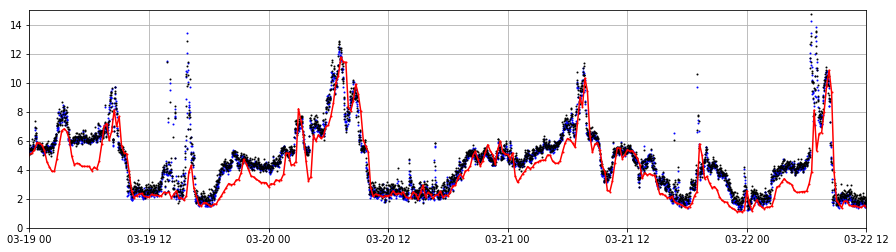

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[15,4])
def plot(x,y,m,ylim,scale,offset):
    plt.plot(x,y*scale+offset,m,markersize=2,alpha=1)
    plt.xlim([pd.to_datetime('2019-03-19 00:00+00:00'),pd.to_datetime('2019-03-22 12:00+00:00')])
    plt.ylim([0,ylim])
    plt.grid()
    
#plt.subplot(3,1,1)
plot(pms5003['created_at'],pms5003['field1'],'b.',50,0.12,0)
plot(pms5003['created_at'],pms5003['field3'],'k.',50,0.12,0)
#plot(alphasenseN2['created_at'],alphasenseN2['field2'],'g.',15,0.4,0)
plot(tno4036data['TimeStamp'],tno4036data['PM2.5 particles (ug/m^3)'],'.-r',15,1,0)

In [5]:
pms5003['seconds'] = (pms5003['created_at']-pd.to_datetime('2019-03-19 00:00+00:00')).dt.total_seconds() #,pms5003['field1']
tno4036data['seconds'] = (tno4036data['TimeStamp']-pd.to_datetime('2019-03-19 00:00')).dt.total_seconds() #,pms5003['field1']

In [94]:
import numpy as np
pms = np.c_[pms5003['seconds'].values/3600,pms5003['field1'].values]
tno = np.c_[tno4036data['seconds'].values/3600,tno4036data['PM2.5 particles (ug/m^3)'].values]
pms = pms[(pms[:,0]>=0) & (pms[:,0]<(24*3))]
tno = tno[(tno[:,0]>=0) & (tno[:,0]<(24*3))]

In [95]:
lowres = []
stepsize = 3
periods = np.arange(0,24*5,stepsize)
for step in periods:
    lowres.append([step,np.mean(tno[(tno[:,0]>=step) & (tno[:,0]<step+stepsize),1])])
lowres = np.array(lowres)
lowres = lowres[~np.isnan(lowres[:,1]),:]

 /home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning:Mean of empty slice.
 /home/ubuntu/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning:invalid value encountered in double_scalars


In [96]:
lowres

array([[ 0.        ,  4.9725    ],
       [ 3.        ,  5.24      ],
       [ 6.        ,  5.7325    ],
       [ 9.        ,  3.61416667],
       [12.        ,  2.29916667],
       [15.        ,  2.32416667],
       [18.        ,  2.3375    ],
       [21.        ,  3.60666667],
       [24.        ,  3.835     ],
       [27.        ,  5.97333333],
       [30.        ,  9.46416667],
       [33.        ,  4.19083333],
       [36.        ,  2.305     ],
       [39.        ,  2.30833333],
       [42.        ,  3.6275    ],
       [45.        ,  5.08583333],
       [48.        ,  4.1425    ],
       [51.        ,  4.805     ],
       [54.        ,  7.11333333],
       [57.        ,  4.4075    ],
       [60.        ,  4.33916667],
       [63.        ,  2.03      ],
       [66.        ,  2.9725    ],
       [69.        ,  1.57416667]])

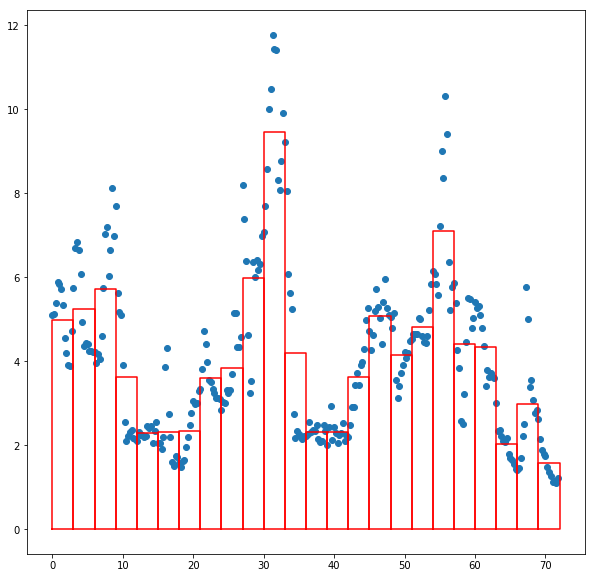

In [97]:
plt.figure(figsize=[10,10])
plt.scatter(tno[:,0],tno[:,1])
for lr in lowres:
    plt.plot([lr[0],lr[0]+stepsize,lr[0]+stepsize,lr[0],lr[0]],[0,0,lr[1],lr[1],0],'r-')

In [98]:
X1 = np.c_[lowres[:,0]+stepsize,lowres[:,0],np.zeros(len(lowres))]
Y1 = lowres[:,1:2]*stepsize

In [99]:
#X2 = np.c_[pms[:,0],np.full(len(pms),np.NaN),np.ones(len(pms))] #maybe need to use another integral
integrationperiod = 60/3600 #np.mean(np.diff(pms[:,0])) #really should find out this
fullX2 = np.c_[pms[:,0]+integrationperiod,pms[:,0],np.zeros(len(pms))] 
fullY2 = pms[:,1:2]*integrationperiod

In [100]:
X2 = []
Y2 = []
stepdown = 5
for i in range(0,len(fullX2)-stepdown,stepdown):
    X2.append([fullX2[i+stepdown-1,0],fullX2[i,1]])
    Y2.append(np.sum(fullY2[i:i+stepdown]))
X2 = np.array(X2)######<<<<<<<<<<<<<<<<<TO DECIDE
X2 = np.c_[X2,np.zeros(len(X2))]
Y2 = np.array(Y2)

In [101]:
tnointegrationperiod = np.median(np.diff(tno[:,0]))
testX1 = np.c_[tno[:,0]+tnointegrationperiod,tno[:,0],np.zeros(len(tno))]
testY1 = tno[:,1]

(0, 20)

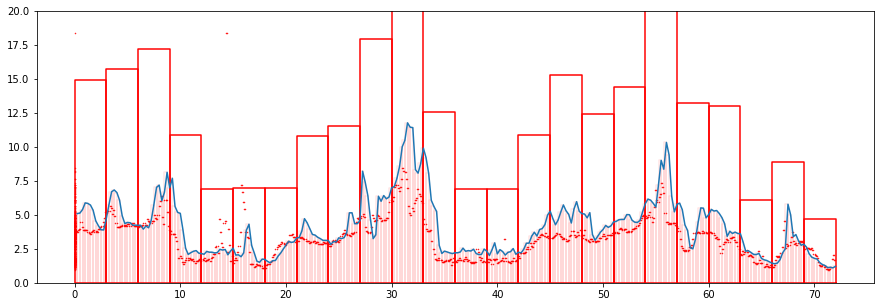

In [102]:
plt.figure(figsize=[15,5])
#plt.plot(X1,Y1/3,'b-')
for x,y in zip(X1,Y1):
    plt.plot([x[0],x[1],x[1],x[0],x[0]],[0,0,y,y,0],'r-')
for x,y in zip(testX1,testY1):
    plt.plot([x[0],x[1],x[1],x[0],x[0]],[0,0,y,y,0],'r-',alpha=0.1)    
plt.plot(X2,Y2,'.r',markersize=1)
plt.plot(testX1[:,0],testY1)
plt.ylim([0,20])

# Analysis

In [103]:
import numpy as np
from scipy.stats import multinomial
from scipy.linalg.blas import dtrmm

import GPy
from GPy.util import choleskies
from GPy.core.parameterization.param import Param
from GPy.kern import Coregionalize
from GPy.likelihoods import Likelihood
from GPy.util import linalg

from hetmogp.util import draw_mini_slices
from hetmogp.het_likelihood import HetLikelihood
#from hetmogp.model import HetMOGP
from hetmogp.svmogp import SVMOGP
#from hetmogp import multi_output
from hetmogp import util
from hetmogp.util import vem_algorithm as VEM

import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
from matplotlib import rc, font_manager
from matplotlib import rcParams
#from matplotlib2tikz import save as tikz_save

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import GPy
import matplotlib.pyplot as plt

In [104]:
from hetmogp.likelihoods.bernoulli import Bernoulli
from hetmogp.likelihoods.gaussian import Gaussian
from hetmogp.likelihoods.categorical import Categorical
from hetmogp.likelihoods.hetgaussian import HetGaussian
from hetmogp.likelihoods.beta import Beta
from hetmogp.likelihoods.gamma import Gamma
from hetmogp.likelihoods.exponential import Exponential

In [105]:
M = 10  # number of inducing points
Q = 1  # number of latent functions

# Heterogeneous Likelihood Definition
# likelihoods_list = [Gaussian(sigma=1.), Bernoulli()] # Real + Binary
#likelihoods_list = [Bernoulli(), Bernoulli()] # Real + Binary
likelihoods_list = [Gaussian(sigma=0.1),Gaussian(sigma=0.01)]

likelihood = HetLikelihood(likelihoods_list)
Y_metadata = likelihood.generate_metadata()

D = likelihood.num_output_functions(Y_metadata)

#W_list, _ = multi_output.random_W_kappas(Q, D, rank=1, experiment=True)
W_list, _ = util.random_W_kappas(Q, D, rank=1, experiment=True)



In [106]:
#X2 = X2[0:1,:]
#Y2 = Y2[0:1]

In [107]:
X = [X1,X2]
Y = [Y1,Y2]

In [143]:
air_pollution_demo_data = {'X':X,'Y':Y,'testX':testX1,'testY':testY1}
import pickle
pickle.dump(air_pollution_demo_data,open('air_pollution_demo_data.p','wb'))


In [108]:
from hetmogp.error_func import snlp, smse, mae

In [145]:
# KERNELS
input_dim = 3
Q = 1
ls_q = np.array(([2.0]*Q))
var_q = np.array(([.5]*Q))
kern_list = util.latent_functions_prior(Q, lengthscale=[ls_q], variance=[var_q], input_dim=input_dim,kernel=GPy.kern.Mix_Integral_)

def callback(i):
    print(i)
    if i['n_iter'] > 4000:
        return True
    return False

X_ = np.vstack((X[0], X[1]))
from sklearn.cluster import KMeans
#kmeans_X = KMeans(n_clusters=100, random_state=0).fit(X_)
#Z = kmeans_X.cluster_centers_
Ninducing = 500
Z = np.zeros([Ninducing,X_.shape[1]])
Z[:,-1] = 1
Z[:,0] = np.linspace(0,24*5,Ninducing)

In [146]:
model = SVMOGP(X=X, Y=Y, Z=Z, kern_list=kern_list, likelihood=likelihood, Y_metadata=Y_metadata,batch_size=70)
model.Z.fix()

 /home/ubuntu/anaconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


array([   0,    1,    2, ..., 1497, 1498, 1499])

In [147]:
model.kern.lengthscale.fix(0.5)
model.kern.variance = 5000 #.fix(5000)
model.kern_q0.lengthscale.fix(0.5)
model.kern_q0.variance = 5000#.fix(5000)

In [ ]:
#vem_model=VEM(model,vem_iters=30,maxIter_perVEM=30,optZ=False,verbose=True,verbose_plot=False,non_chained=True)
import climin
opt = climin.Adam(model.optimizer_array,model.stochastic_grad,step_rate=0.1,decay_mom1=1-0.9, decay_mom2=1-0.999)
opt.minimize_until(callback)

 /home/ubuntu/anaconda3/lib/python3.7/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


{'n_iter': 1, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([1.00000490e-001, 1.00000490e-001, 1.00000490e-001, ...,
       1.00000490e-001, 8.03923814e-295, 9.87287361e-294]), 'offset': 1e-08, 'est_mom1_b': array([1.25685744e+001, 4.14457516e+001, 2.72532895e+001, ...,
       2.83662069e+003, 8.03923894e-303, 9.87287460e-302]), 'est_mom2_b': array([1.57969063e+01, 1.71775032e+02, 7.42741788e+01, ...,
       8.04641696e+05, 0.00000000e+00, 0.00000000e+00]), 'gradient': array([1.25685744e+002, 4.14457516e+002, 2.72532895e+002, ...,
       2.83662069e+004, 8.03923894e-302, 9.87287460e-301]), 'args': [], 'kwargs': {}}
{'n_iter': 2, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([9.94578999e-002, 9.94495041e-002, 9.94672355e-002, ...,
       8.58707849e-002, 8.03915424e-295, 9.87116454e-294]), 'offset': 1e-08, 'est_mom1_b': array([2.23

{'n_iter': 13, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([3.85159625e-002, 3.85312070e-002, 3.82520693e-002, ...,
       3.23135908e-002, 8.03854559e-295, 9.85778971e-294]), 'offset': 1e-08, 'est_mom1_b': array([9.73006583e+002, 3.19000928e+003, 2.28123464e+003, ...,
       2.57993481e+005, 5.99525523e-302, 7.35207193e-301]), 'est_mom2_b': array([1.48261815e+05, 1.59234779e+06, 8.26245889e+05, ...,
       1.48090190e+10, 0.00000000e+00, 0.00000000e+00]), 'gradient': array([ 1.20485315e+002,  3.96741150e+002,  2.61675872e+002, ...,
       -8.53083831e+005,  8.03835694e-302,  9.96964514e-301]), 'args': [], 'kwargs': {}}
{'n_iter': 14, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([3.52570975e-002, 3.52730627e-002, 3.49819364e-002, ...,
       2.28647419e-002, 8.03851712e-295, 9.86192328e-294]), 'offset': 1e-08, 'est_mom1_b': arr

{'n_iter': 25, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([3.50689511e-002, 3.50762695e-002, 3.49372402e-002, ...,
       1.98617445e-002, 8.03807643e-295, 9.85730872e-294]), 'offset': 1e-08, 'est_mom1_b': array([1.85824611e+003, 6.09170002e+003, 4.38117616e+003, ...,
       2.28174452e+005, 7.46102462e-302, 9.14965461e-301]), 'est_mom2_b': array([8.05017971e+05, 8.64758586e+06, 4.50867469e+06, ...,
       3.78393715e+10, 0.00000000e+00, 0.00000000e+00]), 'gradient': array([ 9.66873684e+001,  3.18378688e+002,  2.09990507e+002, ...,
       -3.61851568e+005,  8.03753801e-302,  9.86625952e-301]), 'args': [], 'kwargs': {}}
{'n_iter': 26, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([3.21325689e-002, 3.21400994e-002, 3.19974144e-002, ...,
       3.46690274e-002, 8.03800618e-295, 9.86431327e-294]), 'offset': 1e-08, 'est_mom1_b': arr

{'n_iter': 37, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([3.11778470e-002, 3.11833639e-002, 3.11050148e-002, ...,
       2.97917748e-002, 8.03703488e-295, 9.88117121e-294]), 'offset': 1e-08, 'est_mom1_b': array([2.35109480e+003, 7.70825840e+003, 5.56559993e+003, ...,
       4.15262576e+005, 7.87407958e-302, 9.68082503e-301]), 'est_mom2_b': array([2.15300757e+06, 2.31347133e+07, 1.21216199e+07, ...,
       7.35614623e+10, 0.00000000e+00, 0.00000000e+00]), 'gradient': array([8.17276484e+001, 2.69119617e+002, 1.77500112e+002, ...,
       1.67733680e+006, 8.03619340e-302, 1.00523155e-300]), 'args': [], 'kwargs': {}}
{'n_iter': 38, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([2.84935673e-002, 2.84990822e-002, 2.84180797e-002, ...,
       2.41374143e-002, 8.03694053e-295, 9.84537677e-294]), 'offset': 1e-08, 'est_mom1_b': array([2.

{'n_iter': 49, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([ 2.64413762e-002,  2.64468354e-002,  2.64151367e-002, ...,
       -7.66047066e-002,  8.03611856e-295,  9.80882873e-294]), 'offset': 1e-08, 'est_mom1_b': array([ 2.41943796e+003,  7.93386710e+003,  5.75072467e+003, ...,
       -1.47533125e+006,  7.99010048e-302,  9.75265939e-301]), 'est_mom2_b': array([4.05191587e+06, 4.35533904e+07, 2.29371246e+07, ...,
       1.79501353e+11, 0.00000000e+00, 0.00000000e+00]), 'gradient': array([ 6.62227403e+001,  2.18064178e+002,  1.43826501e+002, ...,
       -6.24610028e+006,  8.03586341e-302,  9.49258562e-301]), 'args': [], 'kwargs': {}}
{'n_iter': 50, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([ 5.78969590e-002,  5.79067714e-002,  5.79689235e-002, ...,
       -3.64037762e-002,  8.03610770e-295,  9.82665351e-294]), 'offset': 1e-08,

{'n_iter': 61, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([ 4.13595904e-002,  4.13624838e-002,  4.13350816e-002, ...,
       -4.62321366e-002,  8.03705386e-295,  9.83205328e-294]), 'offset': 1e-08, 'est_mom1_b': array([ 4.23942886e+003,  1.39010881e+004,  1.00923369e+004, ...,
       -1.15388160e+006,  8.02405554e-302,  9.81615191e-301]), 'est_mom2_b': array([6.24065375e+06, 6.70891379e+07, 3.54090052e+07, ...,
       3.70000580e+11, 0.00000000e+00, 0.00000000e+00]), 'gradient': array([5.61315420e+001, 1.83697496e+002, 1.22748834e+002, ...,
       9.10917118e+005, 8.03847593e-302, 9.87193755e-301]), 'args': [], 'kwargs': {}}
{'n_iter': 62, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([ 3.75852521e-002,  3.75881119e-002,  3.75582167e-002, ...,
       -4.35764160e-002,  8.03722343e-295,  9.83577532e-294]), 'offset': 1e-08, 'est_

{'n_iter': 73, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([2.52793060e-002, 2.52789133e-002, 2.51995378e-002, ...,
       2.14943503e-002, 8.03962875e-295, 9.85197177e-294]), 'offset': 1e-08, 'est_mom1_b': array([2.41402300e+003, 7.91483167e+003, 5.73120484e+003, ...,
       5.55641250e+005, 8.03595652e-302, 9.84747172e-301]), 'est_mom2_b': array([6.42874721e+06, 6.91099218e+07, 3.64653635e+07, ...,
       4.71101136e+11, 0.00000000e+00, 0.00000000e+00]), 'gradient': array([5.06950681e+001, 1.66934900e+002, 1.10103035e+002, ...,
       2.36759121e+006, 8.04185889e-302, 9.97398847e-301]), 'args': [], 'kwargs': {}}
{'n_iter': 74, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([2.29644927e-002, 2.29643663e-002, 2.28875214e-002, ...,
       2.25939653e-002, 8.03988039e-295, 9.85621301e-294]), 'offset': 1e-08, 'est_mom1_b': array([2.

{'n_iter': 85, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([2.08899205e-002, 2.08901298e-002, 2.08209144e-002, ...,
       1.14654238e-002, 8.04278699e-295, 9.86106358e-294]), 'offset': 1e-08, 'est_mom1_b': array([1.90119090e+003, 6.23354325e+003, 4.51266910e+003, ...,
       3.11051784e+005, 8.04174950e-302, 9.85979153e-301]), 'est_mom2_b': array([6.75445427e+06, 7.26106058e+07, 3.83071430e+07, ...,
       6.00202153e+11, 0.00000000e+00, 0.00000000e+00]), 'gradient': array([ 4.72136035e+001,  1.55471491e+002,  1.02541771e+002, ...,
       -2.57892052e+006,  8.04520894e-302,  9.87567576e-301]), 'args': [], 'kwargs': {}}
{'n_iter': 86, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([1.89676353e-002, 1.89680499e-002, 1.89005832e-002, ...,
       1.18207156e-002, 8.04305621e-295, 9.86823597e-294]), 'offset': 1e-08, 'est_mom1_b': arr

{'n_iter': 97, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([1.89250399e-002, 1.89270135e-002, 1.88862454e-002, ...,
       4.15714718e-003, 8.04598322e-295, 9.89110478e-294]), 'offset': 1e-08, 'est_mom1_b': array([1.66993161e+003, 5.47583922e+003, 3.96902812e+003, ...,
       1.19685844e+005, 8.04569014e-302, 9.89074449e-301]), 'est_mom2_b': array([7.20179943e+06, 7.74202287e+07, 4.08502154e+07, ...,
       7.66676281e+11, 0.00000000e+00, 0.00000000e+00]), 'gradient': array([4.38071669e+001, 1.44255211e+002, 9.51434163e+001, ...,
       7.81808122e+005, 8.04833913e-302, 1.00675084e-300]), 'args': [], 'kwargs': {}}
{'n_iter': 98, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([ 1.71740343e-002,  1.71760355e-002,  1.71345577e-002, ...,
       -1.13862299e-002,  8.04624393e-295,  9.85644900e-294]), 'offset': 1e-08, 'est_mom1_b': arr

{'n_iter': 109, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([ 1.60716056e-002,  1.60743062e-002,  1.60465100e-002, ...,
       -2.85606991e-002,  8.04903403e-295,  9.82468377e-294]), 'offset': 1e-08, 'est_mom1_b': array([ 1.38098297e+003,  4.52867116e+003,  3.28422880e+003, ...,
       -8.98639419e+005,  8.04895129e-302,  9.82458277e-301]), 'est_mom2_b': array([7.62860487e+06, 8.20094885e+07, 4.32805361e+07, ...,
       1.02286959e+12, 0.00000000e+00, 0.00000000e+00]), 'gradient': array([ 4.03695541e+001,  1.32936257e+002,  8.76773736e+001, ...,
       -7.82700079e+006,  8.05126336e-302,  9.51077724e-301]), 'args': [], 'kwargs': {}}
{'n_iter': 110, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([4.04131849e-002, 4.04195327e-002, 4.04572974e-002, ...,
       6.18724515e-003, 8.04928058e-295, 9.84275622e-294]), 'offset': 1e-08, 'es

{'n_iter': 121, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([3.87644675e-002, 3.87736883e-002, 3.88640079e-002, ...,
       1.27918961e-002, 8.05191377e-295, 9.85022391e-294]), 'offset': 1e-08, 'est_mom1_b': array([3.38521934e+003, 1.11023119e+004, 8.08818802e+003, ...,
       4.40685483e+005, 8.05189045e-302, 9.85019538e-301]), 'est_mom2_b': array([8.69537570e+06, 9.34835063e+07, 4.93843880e+07, ...,
       1.35322500e+12, 0.00000000e+00, 0.00000000e+00]), 'gradient': array([3.69065066e+001, 1.20357441e+002, 8.10225893e+001, ...,
       2.66395964e+006, 8.05401705e-302, 9.89102338e-301]), 'args': [], 'kwargs': {}}
{'n_iter': 122, 'step_rate': 0.1, 'decay': 0.99999999, 'decay_mom1': 0.09999999999999998, 'decay_mom2': 0.0010000000000000009, 'step': array([3.50825267e-002, 3.50910419e-002, 3.51688043e-002, ...,
       1.20963187e-002, 8.05214629e-295, 9.85402544e-294]), 'offset': 1e-08, 'est_mom1_b': array([

In [ ]:
plt.figure(figsize=[15,12])
plt.subplot(2,1,1)
plt.plot(X2[:,0],Y2/np.median(X2[:,0]-X2[:,1]),'g-')
plt.title('Colocated low-cost sensor')
plt.legend()
plt.grid()
plt.subplot(2,1,2)
plt.title('Reference sensor data and prediction')
means,variances = model.predict(testX1)
mean = means[0]
var = variances[0]
plt.plot(testX1[:,0],4*mean,'b-',label='prediction')
plt.plot(testX1[:,0],4*mean+4*np.sqrt(var)*2,'b-',alpha=0.2)
plt.plot(testX1[:,0],4*mean-4*np.sqrt(var)*2,'b-',alpha=0.2)
plt.plot(testX1[:,0],testY1,'r-',label='true') #test data red line

lab = 'training data'
for x1,y1 in zip(X1,Y1):
    #plt.plot([lr[0],lr[0]+stepsize,lr[0]+stepsize,lr[0],lr[0]],[0,0,lr[1],lr[1],0],'r-')
    plt.plot([x1[0],x1[0]-stepsize,x1[0]-stepsize,x1[0],x1[0]],[0,0,y1/3,y1/3,0],'r-',label=lab)
    lab = None
plt.legend()
plt.grid()
plt.vlines(model.Z,0,1)
plt.ylim([0,20])
plt.xlim([X[0][0,1],X[0][-1,0]])

In [141]:
np.mean(np.abs(testY1 - mean[:,0]))

4.09584821070615

In [130]:
#3.449975592412143 [no extra data]
#3.4329467097085566

In [142]:
model

SVMOGP.,value,constraints,priors
inducing inputs,"(100, 3)",fixed,
m_u,"(100, 1)",,
L_u,"(5050, 1)",,
kern_q0.variance,4998.190253483278,+ve,
kern_q0.lengthscale,0.5,+ve fixed,
B_q0.W,"(2, 1)",,
B_q0.kappa,"(2,)",+ve,
